# Imports

In [3]:
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, PowerTransformer, LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import KFold, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest, RandomForestClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from lightgbm import LGBMClassifier, log_evaluation, early_stopping

pd.set_option('display.max_colwidth', None)

rc = {
    "axes.facecolor": "#2E3440",
    "figure.facecolor": "#2E3440",
    "axes.edgecolor": "#4C566A",
    "grid.color": "#4C566A",
    "font.family": "JetBrains Mono",
    "text.color": "#FFFFFF",
    "axes.labelcolor": "#FFFFFF",
    "xtick.color": "#FFFFFF",
    "ytick.color": "#FFFFFF",
    "grid.alpha": 0.4,
    "font.size": 10,
    "axes.labelsize": 10,
    "axes.titlesize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "legend.title_fontsize": 10
}

bp_props = {
    'boxprops':{'facecolor':'#037d97', 'edgecolor':'white'},
    'medianprops':{'color':'white'},
    'whiskerprops':{'color':'white'},
    'capprops':{'color':'white'},
    'flierprops':{'marker':'x', 'markeredgecolor':'white'}
}

sns.set(rc=rc)

In [54]:
train_df = pd.read_csv('train.csv', index_col='id')
test_df = pd.read_csv('test.csv', index_col='id')

# orig_df = pd.read_csv('original.csv')

for df in [train_df, test_df]:
    df.rename(columns={'height(cm)': 'height', 
                       'weight(kg)': 'weight', 
                       'waist(cm)': 'waist', 
                       'eyesight(left)': 'eyesight_left',
                       'eyesight(right)': 'eyesight_right', 
                       'hearing(left)': 'hearing_left', 
                       'hearing(right)': 'hearing_right',
                       'fasting blood sugar': 'fbs',
                       'Cholesterol': 'cholesterol',
                       'Urine protein': 'up',
                       'serum creatinine': 'sc',
                       'dental caries': 'dc'}, inplace=True)

target_var = 'smoking'
cat_features = ['hearing_left', 'hearing_right', 'up', 'dc', ]
num_features = ['age', 'height', 'weight', 'waist', 'eyesight_left', 'eyesight_right', 'systolic', 'relaxation', 'fbs', 'cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'sc', 'AST', 'ALT', 'Gtp',]

# Data Description

In [3]:
train_df.head()

,age,height,weight,waist,eyesight_left,eyesight_right,hearing_left,hearing_right,systolic,relaxation,...,HDL,LDL,hemoglobin,up,sc,AST,ALT,Gtp,dc,smoking
id,,,,,,,,,,,,,,,,,,,,,
0,55,165,60,81.0,0.5,0.6,1,1,135,87,...,40,75,16.5,1,1.0,22,25,27,0,1
1,70,165,65,89.0,0.6,0.7,2,2,146,83,...,57,126,16.2,1,1.1,27,23,37,1,0
2,20,170,75,81.0,0.4,0.5,1,1,118,75,...,45,93,17.4,1,0.8,27,31,53,0,1
3,35,180,95,105.0,1.5,1.2,1,1,131,88,...,38,102,15.9,1,1.0,20,27,30,1,0
4,30,165,60,80.5,1.5,1.0,1,1,121,76,...,44,93,15.4,1,0.8,19,13,17,0,1


## Shape and Columns

In [4]:
print('Train Descriptors')
print(f'Shape: {train_df.shape}')
print(f'Columns : {train_df.columns}')
print('')
print('Test Descriptors')
print(f'Shape: {test_df.shape}')
print(test_df.columns)

Train Descriptors
Shape: (159256, 23)
Columns : Index(['age', 'height', 'weight', 'waist', 'eyesight_left', 'eyesight_right',
       'hearing_left', 'hearing_right', 'systolic', 'relaxation', 'fbs',
       'cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'up', 'sc',
       'AST', 'ALT', 'Gtp', 'dc', 'smoking'],
      dtype='object')

Test Descriptors
Shape: (106171, 22)
Index(['age', 'height', 'weight', 'waist', 'eyesight_left', 'eyesight_right',
       'hearing_left', 'hearing_right', 'systolic', 'relaxation', 'fbs',
       'cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'up', 'sc',
       'AST', 'ALT', 'Gtp', 'dc'],
      dtype='object')


## Missing Values

In [5]:
null_values = {'column': [], 'train_null_values': [], 'test_null_values': []}

for col in test_df.columns:
    train_col_null = train_df[col].isna().sum()
    test_col_null = test_df[col].isna().sum()
    
    null_values['column'].append(col)
    null_values['train_null_values'].append(train_col_null)
    null_values['test_null_values'].append(test_col_null)
    
null_values = pd.DataFrame(null_values)
null_values['train_total'] = train_df.shape[0]
null_values['test_total'] = test_df.shape[0]
null_values['train_null_perc'] = null_values['train_null_values'] / null_values['train_total']
null_values['test_null_perc'] = null_values['test_null_values'] / null_values['test_total']
null_values.sort_values(by='train_null_perc', inplace=True, ascending=False)

null_values.style.format({'train_null_perc': '{:.0%}',
                          'test_null_perc': '{:.0%}'})

,column,train_null_values,test_null_values,train_total,test_total,train_null_perc,test_null_perc
0,age,0,0,159256,106171,0%,0%
1,height,0,0,159256,106171,0%,0%
20,Gtp,0,0,159256,106171,0%,0%
19,ALT,0,0,159256,106171,0%,0%
18,AST,0,0,159256,106171,0%,0%
17,sc,0,0,159256,106171,0%,0%
16,up,0,0,159256,106171,0%,0%
15,hemoglobin,0,0,159256,106171,0%,0%
14,LDL,0,0,159256,106171,0%,0%
13,HDL,0,0,159256,106171,0%,0%


In [6]:
null_values_per_row = train_df.isna().sum(axis=1)
pd.DataFrame(null_values_per_row.value_counts().sort_index())

,count
0,159256


In [7]:
missing_values = {'column': [], 'only_in_train': [], 'only_in_test': []}

for col in cat_features:
    train_col_unique = train_df[col].unique()
    test_col_unique = test_df[col].unique()
    
    missing_values['column'].append(col)
    missing_values['only_in_train'].append([f for f in train_col_unique if f not in test_col_unique])
    missing_values['only_in_test'].append([f for f in test_col_unique if f not in train_col_unique])

missing_values = pd.DataFrame(missing_values)
missing_values

,column,only_in_train,only_in_test
0,hearing_left,[],[]
1,hearing_right,[],[]
2,up,[],[]
3,dc,[],[]


## Adversarial Testing

### Train vs Test

In [8]:
df = pd.concat([train_df[num_features].assign(source=0), test_df[num_features].assign(source=1)], ignore_index=True)
origin_var = df['source']
df.drop(columns='source', inplace=True)

n_folds = 5
k_fold = KFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((df.shape[0],))
train_oof_probas = np.zeros((df.shape[0],))

for fold, (train_index, test_index) in enumerate(k_fold.split(df, origin_var)):
    print('-----> Fold {} <-----'.format(fold+1))
    X_train, X_valid = pd.DataFrame(df.iloc[train_index]), pd.DataFrame(df.iloc[test_index])
    y_train, y_valid = origin_var.iloc[train_index], origin_var.iloc[test_index]
    
    model = LGBMClassifier(
        random_state=2023,
        objective='binary',
        metric='auc',
        n_jobs=-1,
        n_estimators=2000,
        verbose=-1,
        max_depth=3,
    )
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[
            early_stopping(50, verbose=False),
            log_evaluation(2000),
        ]
    )
    
    oof_preds = model.predict(X_valid)
    oof_probas = model.predict_proba(X_valid)[:,1]
    train_oof_preds[test_index] = oof_preds
    train_oof_probas[test_index] = oof_probas
    print(': AUC ROC = {}'.format(roc_auc_score(y_valid, oof_probas)))

auc_vanilla = roc_auc_score(origin_var, train_oof_probas)
fpr, tpr, _ = roc_curve(origin_var, train_oof_probas)
print("--> Overall results for out of fold predictions")
print(": AUC ROC = {}".format(auc_vanilla))

-----> Fold 1 <-----
: AUC ROC = 0.5018371905443353
-----> Fold 2 <-----
: AUC ROC = 0.503032969230766
-----> Fold 3 <-----
: AUC ROC = 0.5019569689012746
-----> Fold 4 <-----
: AUC ROC = 0.5033639018608528
-----> Fold 5 <-----
: AUC ROC = 0.5023024726730336
--> Overall results for out of fold predictions
: AUC ROC = 0.5018332923128576


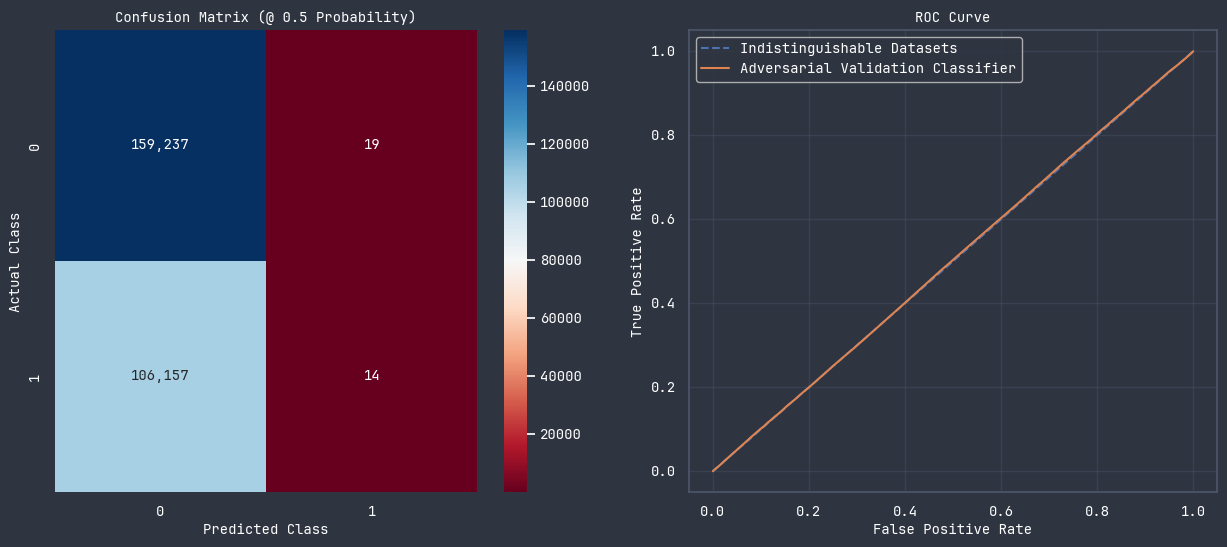

In [9]:
confusion = confusion_matrix(origin_var, train_oof_preds)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

sns.heatmap(confusion, annot=True, fmt=",d", cmap='RdBu', ax=axs[0])
axs[0].set_title("Confusion Matrix (@ 0.5 Probability)")
axs[0].set_ylabel("Actual Class")
axs[0].set_xlabel("Predicted Class")

sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets", ax=axs[1])
sns.lineplot(x=fpr, y=tpr, ax=axs[1], label="Adversarial Validation Classifier")
axs[1].set_title("ROC Curve")
axs[1].set_xlabel("False Positive Rate")
axs[1].set_ylabel("True Positive Rate")

plt.show()

### Train/Test Original

In [ ]:
df = pd.concat([train_df[num_features].assign(source=0), test_df[num_features].assign(source=0), orig_df[num_features].assign(source=1)], ignore_index=True)
origin_var = df['source']
df.drop(columns='source', inplace=True)

n_folds = 5
k_fold = KFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((df.shape[0],))
train_oof_probas = np.zeros((df.shape[0],))

for fold, (train_index, test_index) in enumerate(k_fold.split(df, origin_var)):
    print('-----> Fold {} <-----'.format(fold+1))
    X_train, X_valid = pd.DataFrame(df.iloc[train_index]), pd.DataFrame(df.iloc[test_index])
    y_train, y_valid = origin_var.iloc[train_index], origin_var.iloc[test_index]
    
    model = LGBMClassifier(
        random_state=2023,
        objective='binary',
        metric='auc',
        n_jobs=-1,
        n_estimators=2000,
        verbose=-1,
        max_depth=3,
    )
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[
            early_stopping(50, verbose=False),
            log_evaluation(2000),
        ]
    )
    
    oof_preds = model.predict(X_valid)
    oof_probas = model.predict_proba(X_valid)[:,1]
    train_oof_preds[test_index] = oof_preds
    train_oof_probas[test_index] = oof_probas
    print(': AUC ROC = {}'.format(roc_auc_score(y_valid, oof_probas)))

auc_vanilla = roc_auc_score(origin_var, train_oof_probas)
fpr, tpr, _ = roc_curve(origin_var, train_oof_probas)
print("--> Overall results for out of fold predictions")
print(": AUC ROC = {}".format(auc_vanilla))

In [ ]:
confusion = confusion_matrix(origin_var, train_oof_preds)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,6))

sns.heatmap(confusion, annot=True, fmt=",d", cmap='RdBu', ax=axs[0])
axs[0].set_title("Confusion Matrix (@ 0.5 Probability)")
axs[0].set_ylabel("Actual Class")
axs[0].set_xlabel("Predicted Class")

sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets", ax=axs[1])
sns.lineplot(x=fpr, y=tpr, ax=axs[1], label="Adversarial Validation Classifier")
axs[1].set_title("ROC Curve")
axs[1].set_xlabel("False Positive Rate")
axs[1].set_ylabel("True Positive Rate")

plt.show()

# Exploratory Data Analysis

## Variable Distribution

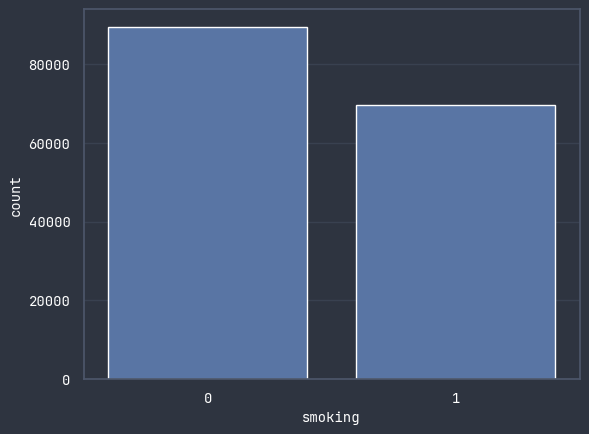

In [49]:
sns.countplot(data=train_df, x=target_var)
plt.show()

## Variable Correlation

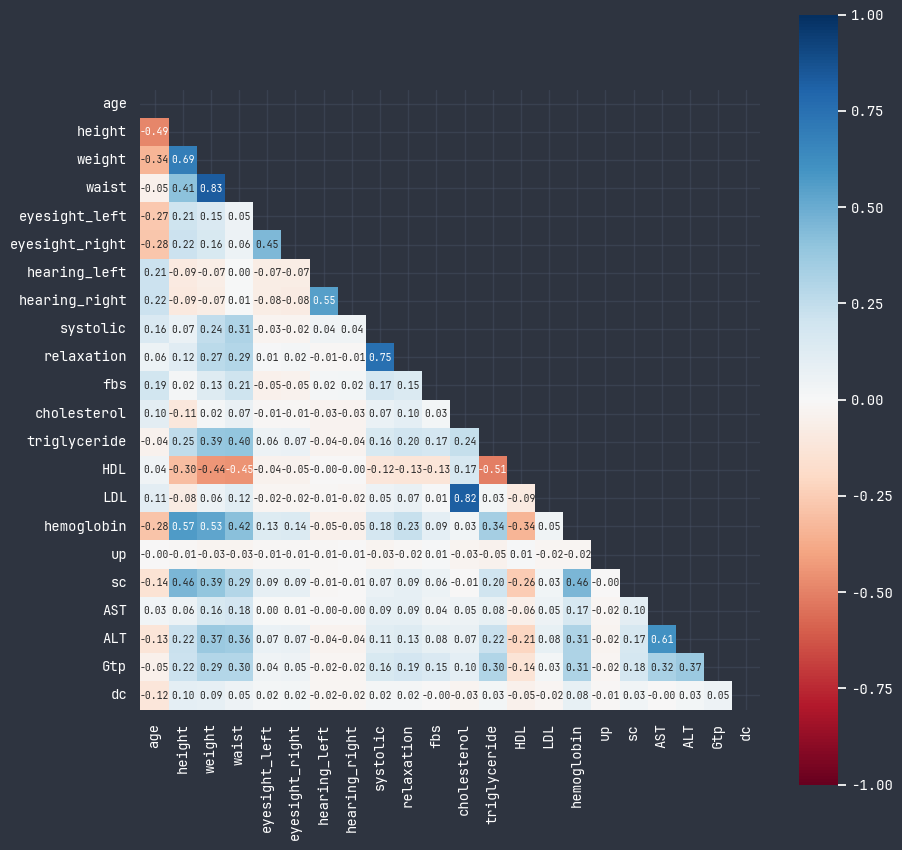

In [51]:
df = pd.concat([train_df[test_df.columns], test_df], ignore_index=True)
df_corr = df.corr(method='pearson')
mask = np.triu(np.ones_like(df_corr, dtype=bool))

plt.figure(figsize=(10, 10))
sns.heatmap(df_corr, mask=mask, annot=True, annot_kws={"size": 7}, fmt='.2f', cmap='RdBu', square=True, vmin=-1, vmax=1)
plt.show()

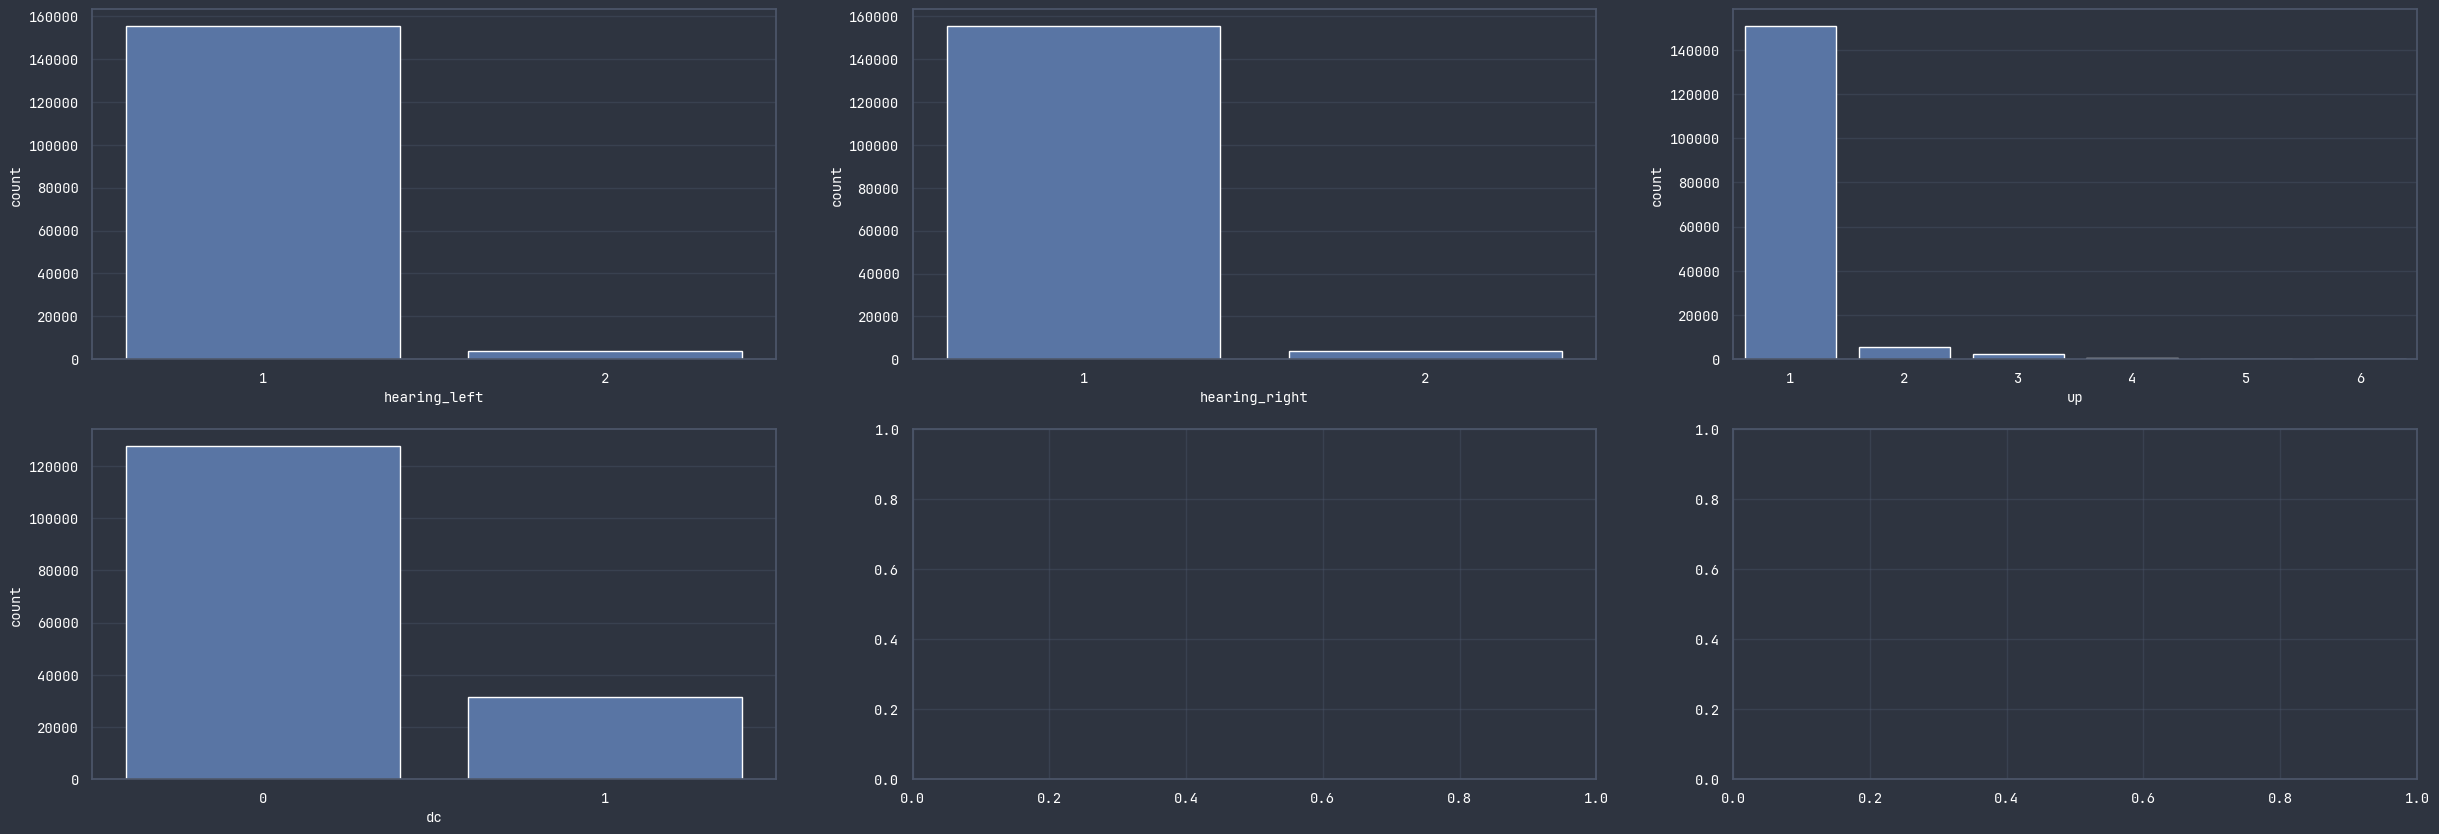

In [55]:
fig, axs = plt.subplots(nrows=len(cat_features)//3 + 1, ncols=3, figsize=(30, 5 * (len(cat_features)//3 + 1)))
axs = axs.flatten()

for i, feat in enumerate(cat_features):
    sns.countplot(data=train_df, x=feat, ax=axs[i])
plt.show()

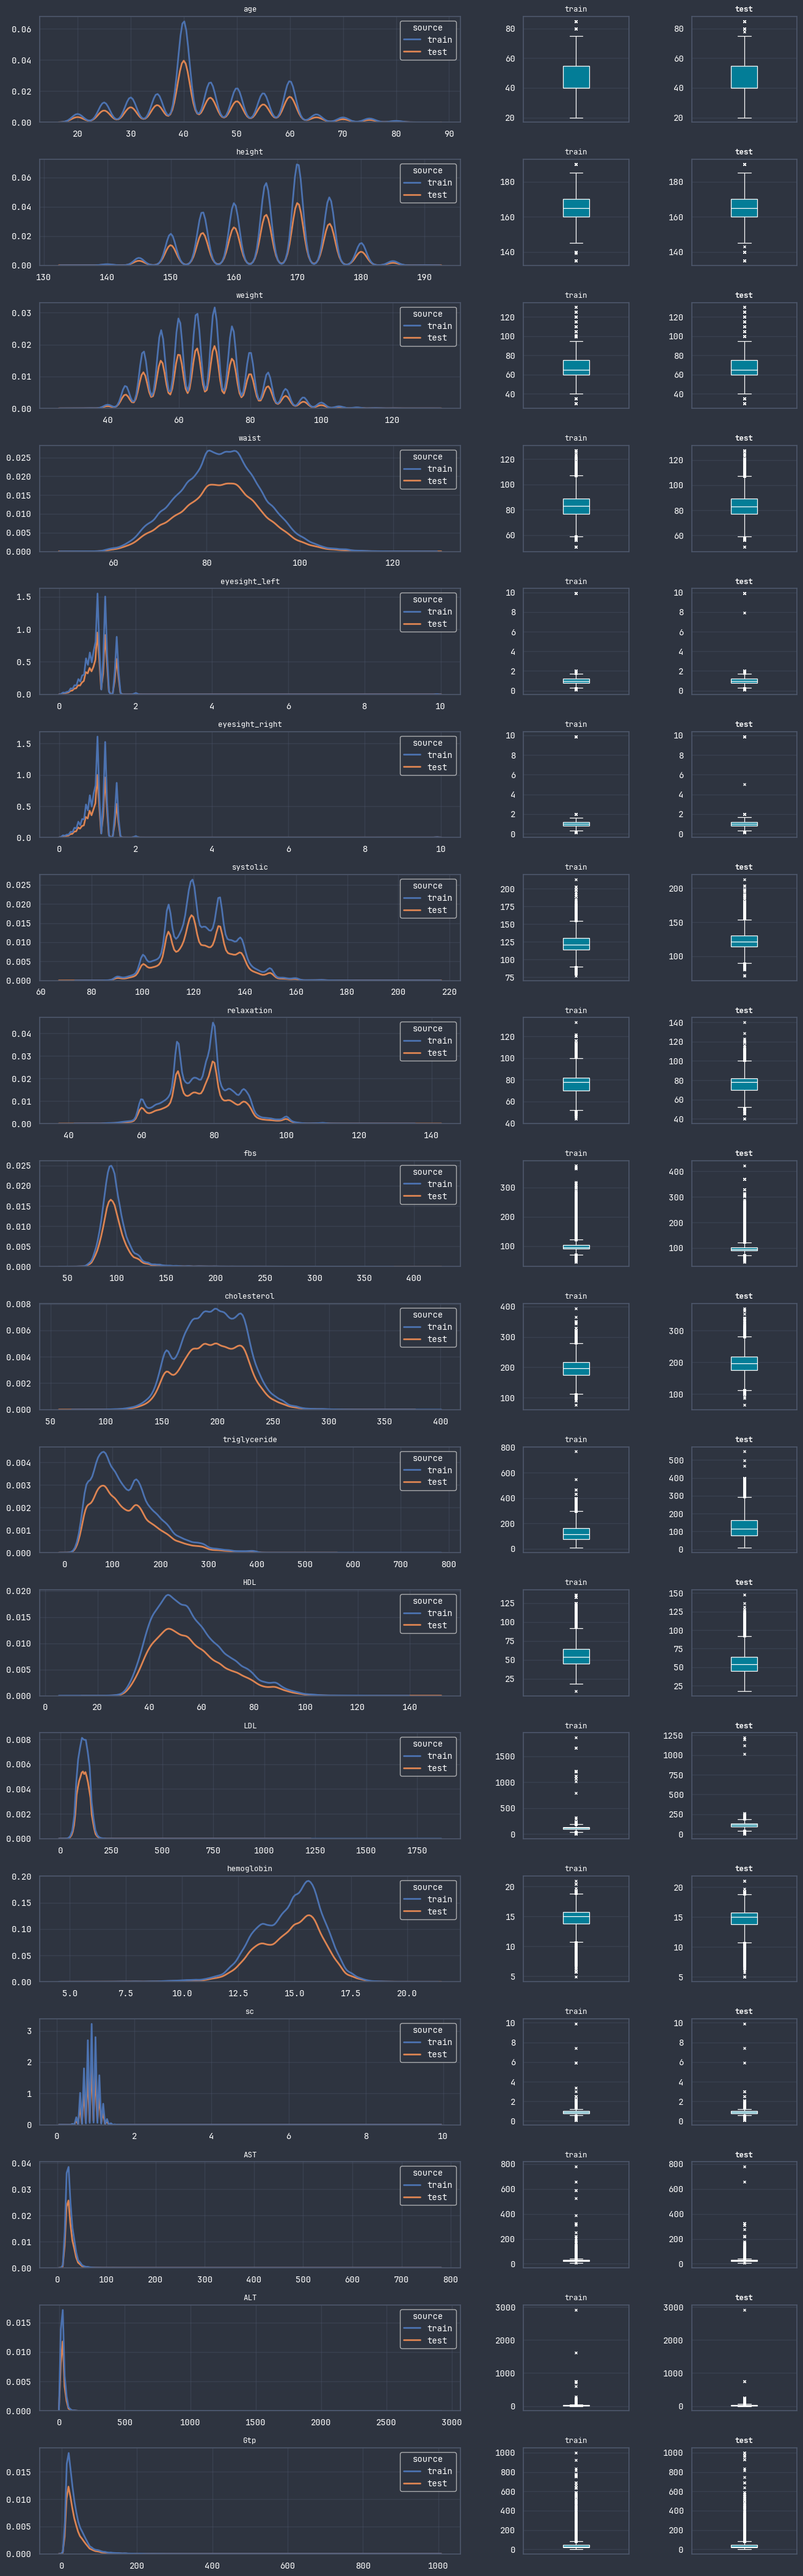

In [77]:
df = pd.concat([train_df[num_features].assign(source='train'), test_df[num_features].assign(source='test')], ignore_index=True)

fig, axs = plt.subplots(nrows=len(num_features), ncols=3, figsize=(16, len(num_features) * 3),
                        gridspec_kw= {'hspace': 0.35, 'wspace': 0.3, 'width_ratios': [0.8, 0.2, 0.2]})

for i, feat in enumerate(num_features):
    sns.kdeplot(data=df[[feat, 'source']], x=feat, hue='source', linewidth=2, ax=axs[i, 0])
    axs[i, 0].set_title(feat, fontsize=9)
    axs[i, 0].set(xlabel='', ylabel='')
    
    sns.boxplot(data=df.loc[df['source'] == 'train', [feat]], y=feat, width=0.25, saturation=0.9, linewidth=0.9, fliersize=2.25, ax=axs[i, 1], **bp_props)
    axs[i, 1].set_title('train', fontsize=9)
    axs[i, 1].set(xlabel='', ylabel='')
    
    sns.boxplot(data=df.loc[df['source'] == 'test', [feat]], y=feat, width=0.25, saturation=0.9, linewidth=0.9, fliersize=2.25, color='#037d97', ax=axs[i, 2], **bp_props)
    axs[i, 2].set_title('test', fontsize=9, fontweight='bold')
    axs[i, 2].set(xlabel='', ylabel='')

plt.tight_layout()
plt.show()

# Feature Engineering

## Outliers

### Isolation Forest

In [104]:
iso = IsolationForest(contamination='auto', random_state=2023)
outlier_preds = iso.fit_predict(train_df)
outlier_df = train_df[outlier_preds == -1]

print(f'Number of Outliers: {outlier_df.shape[0]}')
print(f'Percentage of Rows: {round(100 * outlier_df.shape[0] / train_df.shape[0], 2)}%')

Number of Outliers: 6948
Percentage of Rows: 4.36%


### Quantiles

In [50]:
for feat in num_features:
    feat_min = np.min(train_df[feat])
    q1 = train_df[feat].quantile(0.01)
    q3 = train_df[feat].quantile(0.999)
    feat_max = np.max(train_df[feat])
    print(f'{feat} - Min: {feat_min}, Q1: {q1}, Q3: {q3}, Max: {feat_max}')

age - Min: 20, Q1: 20.0, Q3: 80.0, Max: 85
height - Min: 135, Q1: 145.0, Q3: 185.0, Max: 190
weight - Min: 30, Q1: 45.0, Q3: 110.0, Max: 130
waist - Min: 51.0, Q1: 63.0, Q3: 112.0, Max: 127.0
eyesight_left - Min: 0.1, Q1: 0.2, Q3: 2.0, Max: 9.9
eyesight_right - Min: 0.1, Q1: 0.2, Q3: 2.0, Max: 9.9
systolic - Min: 77, Q1: 95.0, Q3: 170.0, Max: 213
relaxation - Min: 44, Q1: 59.0, Q3: 110.0, Max: 133
fbs - Min: 46, Q1: 75.0, Q3: 240.0, Max: 375
cholesterol - Min: 77, Q1: 136.0, Q3: 292.0, Max: 393
triglyceride - Min: 8, Q1: 34.0, Q3: 393.0, Max: 766
HDL - Min: 9, Q1: 33.0, Q3: 106.0, Max: 136
LDL - Min: 1, Q1: 60.0, Q3: 203.0, Max: 1860
hemoglobin - Min: 4.9, Q1: 10.9, Q3: 18.4, Max: 21.0
sc - Min: 0.1, Q1: 0.5, Q3: 1.5, Max: 9.9
AST - Min: 6, Q1: 14.0, Q3: 86.0, Max: 778
ALT - Min: 1, Q1: 9.0, Q3: 130.0, Max: 2914
Gtp - Min: 2, Q1: 9.0, Q3: 313.23500000007334, Max: 999


### Manual Examinatoin

In [106]:
print(np.sort(train_df[outlier_preds == -1]['eyesight_left'].unique()))
print(np.sort(train_df[outlier_preds == -1]['eyesight_right'].unique()))
print(np.sort(train_df[outlier_preds == -1]['hearing_left'].unique()))
print(np.sort(train_df[outlier_preds == -1]['hearing_right'].unique()))

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.2 1.3 1.5 1.6 1.7 1.8 2.  9.9]
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.2 1.3 1.5 1.6 2.  9.9]
[1 2]
[1 2]


## Numerical Transformations

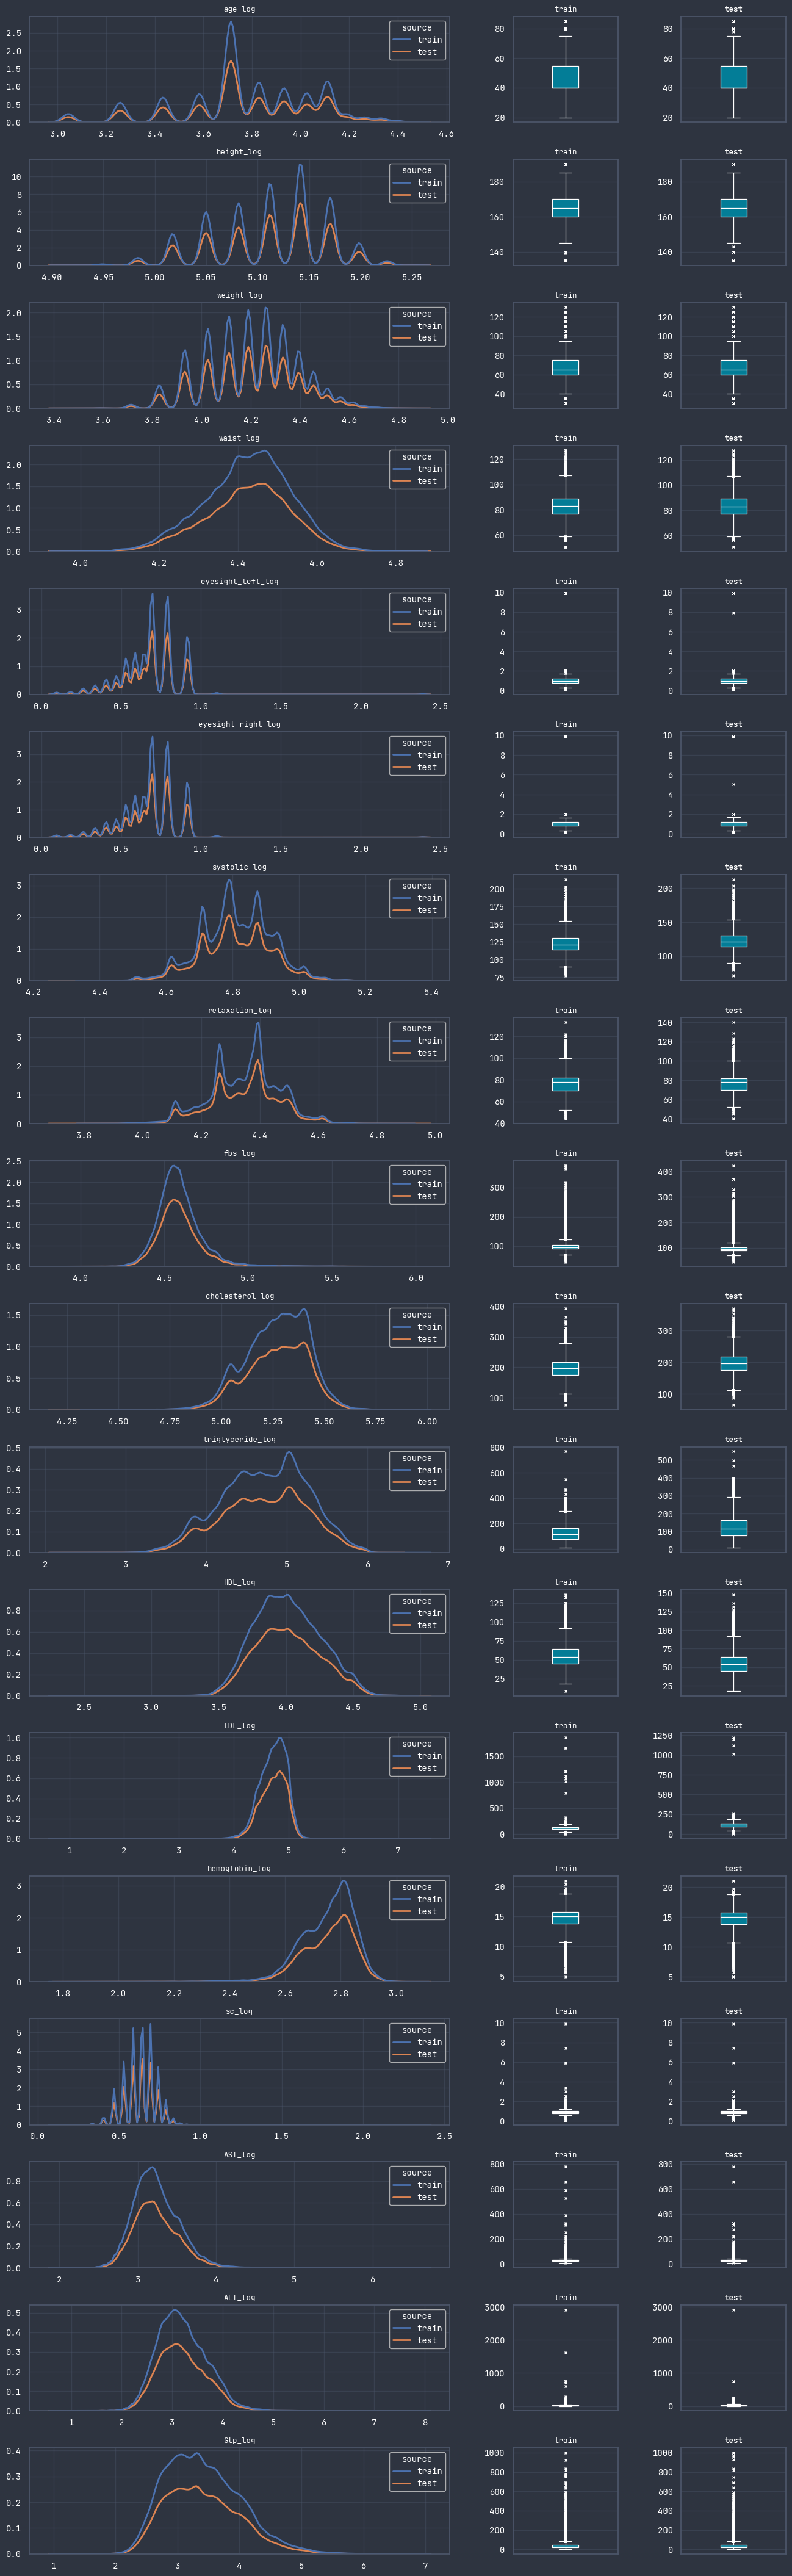

In [110]:
df = pd.concat([train_df[num_features].assign(source='train'), test_df[num_features].assign(source='test')], ignore_index=True)

fig, axs = plt.subplots(nrows=len(num_features), ncols=3, figsize=(16, len(num_features) * 3),
                        gridspec_kw= {'hspace': 0.35, 'wspace': 0.3, 'width_ratios': [0.8, 0.2, 0.2]})

for i, feat in enumerate(num_features):
    df[feat + '_log'] = np.log1p(df[feat])
    sns.kdeplot(data=df[[feat + '_log', 'source']], x=feat + '_log', hue='source', linewidth=2, ax=axs[i, 0])
    axs[i, 0].set_title(feat + '_log', fontsize=9)
    axs[i, 0].set(xlabel='', ylabel='')
    
    sns.boxplot(data=df.loc[df['source'] == 'train', [feat]], y=feat, width=0.25, saturation=0.9, linewidth=0.9, fliersize=2.25, ax=axs[i, 1], **bp_props)
    axs[i, 1].set_title('train', fontsize=9)
    axs[i, 1].set(xlabel='', ylabel='')
    
    sns.boxplot(data=df.loc[df['source'] == 'test', [feat]], y=feat, width=0.25, saturation=0.9, linewidth=0.9, fliersize=2.25, color='#037d97', ax=axs[i, 2], **bp_props)
    axs[i, 2].set_title('test', fontsize=9, fontweight='bold')
    axs[i, 2].set(xlabel='', ylabel='')

plt.tight_layout()
plt.show()

In [3]:
df = train_df.copy()[num_features + [target_var]]

mms = MinMaxScaler()
for feat in num_features:
    df[feat] = mms.fit_transform(df[feat].values.reshape(-1,1))

best_features = pd.DataFrame()

for i in tqdm(range(len(num_features)), desc='Features'):
    feat = num_features[i]
    trans_feat_score = pd.DataFrame()
    
    # Log
    df[feat + '_log'] = np.log1p(df[feat])
    
    # Square Root
    df[feat + '_sqrt'] = np.sqrt(df[feat])
    
    # Box Cox
    epsl = 1e-5
    transformer = PowerTransformer(method='box-cox')
    df[feat + '_boxcox'] = transformer.fit_transform((df[[feat]] + epsl))
    
    # Yeo Johnson
    transformer = PowerTransformer(method='yeo-johnson')
    df[feat + '_yeojohn'] = transformer.fit_transform(df[[feat]])
    
    # Power Transform (0.25)
    df[feat + '_power0.25'] = np.power(df[feat], 0.25)
    
    # Power Transform (2)
    df[feat + '_power2'] = np.power(df[feat], 2)
    
    # Log Power Transform
    df[feat + '_log_power'] = np.log1p(df[feat + '_sqrt'])
    
    trans_feat = [f for f in df.columns if feat in f]
    df[trans_feat] = df[trans_feat].fillna(0)
    
    pca = TruncatedSVD(n_components=1)
    pca_df = pd.DataFrame(pca.fit_transform(df[trans_feat]), columns=[feat + '_pca'])
    
    df = pd.concat([df, pca_df], axis=1)
    trans_feat.append(feat + '_pca')
    
    k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
    col_score = []
    
    for col in trans_feat:
        X_col = df[col]
        y_col = df[target_var]
        oof_score = []
        
        for fold, (train_idx, test_idx) in enumerate(k_fold.split(X_col, y_col)):
            X_train, X_valid = X_col.iloc[train_idx], X_col.iloc[test_idx]
            y_train, y_valid = y_col.iloc[train_idx], y_col.iloc[test_idx]
            
            model = LogisticRegression()
            
            model.fit(X_train.values.reshape(-1, 1), y_train)
            
            oof_preds = model.predict(X_valid.values.reshape(-1, 1))
            oof_score.append(roc_auc_score(y_valid, oof_preds))
        col_score.append(np.mean(oof_score))
        
    trans_feat_score = pd.concat([trans_feat_score, pd.DataFrame({'feature': feat, 'transformed': trans_feat, 'trans_score': col_score})])
    best_trans_feat_score, best_trans_feat = trans_feat_score.groupby('trans_score')['transformed'].apply(', '.join).reset_index().sort_values('trans_score', ascending=False).iloc[0]
    orig_score = trans_feat_score.loc[trans_feat_score['transformed'] == feat, 'trans_score'][0]
    
    best_features = pd.concat([best_features, pd.DataFrame({
        'feature': [feat],
        'best_trans_feat': [best_trans_feat],
        'orig_score': [orig_score],
        'trans_score': [best_trans_feat_score],
        'gain': [best_trans_feat_score - orig_score]
    })])

Features:   0%|          | 0/18 [00:00<?, ?it/s]

In [4]:
best_features[best_features['gain'] != 0]

,feature,best_trans_feat,orig_score,trans_score,gain
0,waist,waist_log_power,0.581917,0.589580,0.007663
0,systolic,systolic_power2,0.496092,0.498863,0.002771
0,fbs,fbs_yeojohn,0.512008,0.517603,0.005595
0,cholesterol,cholesterol_power0.25,0.500323,0.500480,0.000157
0,triglyceride,"triglyceride_boxcox, triglyceride_yeojohn, triglyceride_pca",0.621043,0.634951,0.013907
0,HDL,HDL_power2,0.608634,0.612993,0.004359
0,LDL,LDL_log_power,0.503111,0.504935,0.001824
0,hemoglobin,hemoglobin_power0.25,0.686110,0.690594,0.004485
0,AST,AST_yeojohn,0.503655,0.506238,0.002582
0,ALT,ALT_yeojohn,0.525518,0.581409,0.055891


In [5]:
best_features[best_features['gain'] == 0]

,feature,best_trans_feat,orig_score,trans_score,gain
0,age,"age, age_log, age_boxcox, age_yeojohn, age_power2, age_pca",0.566897,0.566897,0.0
0,height,"height, height_log, height_sqrt, height_boxcox, height_yeojohn, height_power0.25, height_power2, height_log_power, height_pca",0.687532,0.687532,0.0
0,weight,"weight, weight_log, weight_sqrt, weight_boxcox, weight_yeojohn, weight_power0.25, weight_power2, weight_log_power, weight_pca",0.619641,0.619641,0.0
0,eyesight_left,"eyesight_left, eyesight_left_log, eyesight_left_sqrt, eyesight_left_boxcox, eyesight_left_yeojohn, eyesight_left_power0.25, eyesight_left_log_power, eyesight_left_pca",0.528997,0.528997,0.0
0,eyesight_right,"eyesight_right, eyesight_right_log, eyesight_right_sqrt, eyesight_right_boxcox, eyesight_right_power0.25, eyesight_right_log_power",0.528838,0.528838,0.0
0,relaxation,relaxation,0.513408,0.513408,0.0
0,sc,"sc, sc_log, sc_sqrt, sc_boxcox, sc_yeojohn, sc_power0.25, sc_log_power, sc_pca",0.598329,0.598329,0.0


# Data Preprocessing

In [144]:
params = {
    'feature_engineering': True, # Add new features
    'num_transform': True, # Transformations for numerical features
    'drop_orig_feats': False, # Drop original features after transformation
    'drop_outliers': True, # Drop outliers from IsolationForest
    'clip_data_manual': True # Clip features manually
}

cleaned_train_df = train_df.copy()

if params['drop_outliers']:
    iso = IsolationForest(contamination='auto', random_state=2023)
    outlier_preds = iso.fit_predict(cleaned_train_df)
    cleaned_train_df = cleaned_train_df[outlier_preds != -1]

if params['clip_data_manual']:
    cleaned_train_df['Gtp'] = np.clip(cleaned_train_df['Gtp'], 0, 300)
    cleaned_train_df['HDL'] = np.clip(cleaned_train_df['HDL'], 0, 110)
    cleaned_train_df['LDL'] = np.clip(cleaned_train_df['LDL'], 0, 200)
    cleaned_train_df['ALT'] = np.clip(cleaned_train_df['ALT'], 0, 150)
    cleaned_train_df['AST'] = np.clip(cleaned_train_df['AST'], 0, 100)
    cleaned_train_df['sc'] = np.clip(cleaned_train_df['sc'], 0, 3)

combined_df = pd.concat([cleaned_train_df, test_df], ignore_index=True)

if params['feature_engineering']:
    
    # additional hearing features
    combined_df['hearing_worst'] = np.where(combined_df['hearing_left'] < combined_df['hearing_right'], combined_df['hearing_left'], combined_df['hearing_right']) - 1
    combined_df['hearing_best'] = np.where(combined_df['hearing_left'] > combined_df['hearing_right'], combined_df['hearing_left'], combined_df['hearing_right']) - 1
    combined_df['hearing_combined'] = combined_df['hearing_left'] + combined_df['hearing_right'] - 2
    
    # additional eyesight features
    combined_df['eyesight_left'] = np.where(combined_df['eyesight_left'] > 9, 0, combined_df['eyesight_left'])
    combined_df['eyesight_right'] = np.where(combined_df['eyesight_right'] > 9, 0, combined_df['eyesight_right'])
    combined_df['eyesight_worst'] = np.where(combined_df['eyesight_left'] < combined_df['eyesight_right'], combined_df['eyesight_left'], combined_df['eyesight_right'])
    combined_df['eyesight_best'] = np.where(combined_df['eyesight_left'] > combined_df['eyesight_right'], combined_df['eyesight_left'], combined_df['eyesight_right'])
    combined_df['eyesight_combined'] = combined_df['eyesight_left'] + combined_df['eyesight_right']
    
    # bmi
    combined_df['bmi'] = np.divide(combined_df['weight'], np.square(combined_df['height']/100))
    
    bmi_groups = [
        combined_df['bmi'].le(18.4),
        combined_df['bmi'].ge(18.5) & combined_df['bmi'].le(24.9),
        combined_df['bmi'].ge(25.0) & combined_df['bmi'].le(39.9),
        combined_df['bmi'].ge(40.0)
    ]
    combined_df['bmi_category'] = np.select(bmi_groups, range(0,4))

if params['num_transform']:
    log_feats = num_features
    sqrt_feats = []
    boxcox_feats = []
    yeojohn_feats = ['fbs', 'AST', 'ALT']
    power025_feats = ['cholesterol', 'hemoglobin']
    power2_feats = ['systolic', 'HDL']
    log_power_feats = ['waist', 'LDL']
    pca_feats = ['triglyceride', 'Gtp']
    
    for feat in (log_feats + pca_feats):
        combined_df[feat + '_log'] = np.log1p(combined_df[feat])
        
    for feat in (sqrt_feats + pca_feats):
        combined_df[feat + '_sqrt'] = np.sqrt(combined_df[feat])
    
    for feat in (boxcox_feats + pca_feats):
        epsl = 1e-5
        transformer = PowerTransformer(method='box-cox')
        combined_df[feat + '_boxcox'] = transformer.fit_transform((combined_df[[feat]] + epsl))
    
    for feat in (yeojohn_feats + pca_feats):
        transformer = PowerTransformer(method='yeo-johnson')
        combined_df[feat + '_yeojohn'] = transformer.fit_transform(combined_df[[feat]])
    
    for feat in (power025_feats + pca_feats):
        combined_df[feat + '_power0.25'] = np.power(combined_df[feat], 0.25)
    
    for feat in (power2_feats + pca_feats):
        combined_df[feat + '_power2'] = np.power(combined_df[feat], 2)
    
    for feat in (log_power_feats + pca_feats):
        combined_df[feat + '_log_power'] = np.log1p(np.sqrt(combined_df[feat]))
    
    for feat in pca_feats:
        trans_feat = [f for f in combined_df.columns if feat in f]
        trans_feat.remove(feat)
        
        pca = TruncatedSVD(n_components=1)
        pca_df = pd.DataFrame(pca.fit_transform(combined_df[trans_feat]), columns=[feat + '_pca'])
        
        combined_df = pd.concat([combined_df, pca_df], axis=1).drop(columns=trans_feat)
    
    if params['drop_orig_feats']:
            combined_df = combined_df.drop(columns=(log_feats + sqrt_feats + boxcox_feats + yeojohn_feats + power025_feats + power2_feats + log_power_feats + pca_feats))


cleaned_train_df = combined_df[~combined_df[target_var].isnull()]
cleaned_test_df = combined_df[combined_df[target_var].isnull()].drop(target_var, axis=1)

In [152]:
cleaned_train_df.columns

Index(['age', 'height', 'weight', 'waist', 'eyesight_left', 'eyesight_right',
       'hearing_left', 'hearing_right', 'systolic', 'relaxation', 'fbs',
       'cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'up', 'sc',
       'AST', 'ALT', 'Gtp', 'dc', 'smoking', 'hearing_worst', 'hearing_best',
       'hearing_combined', 'eyesight_worst', 'eyesight_best',
       'eyesight_combined', 'bmi', 'bmi_category', 'age_log', 'height_log',
       'weight_log', 'waist_log', 'eyesight_left_log', 'eyesight_right_log',
       'systolic_log', 'relaxation_log', 'fbs_log', 'cholesterol_log',
       'HDL_log', 'LDL_log', 'hemoglobin_log', 'sc_log', 'AST_log', 'ALT_log',
       'fbs_yeojohn', 'AST_yeojohn', 'ALT_yeojohn', 'cholesterol_power0.25',
       'hemoglobin_power0.25', 'systolic_power2', 'HDL_power2',
       'waist_log_power', 'LDL_log_power', 'triglyceride_pca', 'Gtp_pca'],
      dtype='object')

# Model Evaluation

## Base Model

In [153]:
# Cross Fold Training
n_folds = 5
k_fold = KFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((cleaned_train_df.shape[0],))
oof_metric = []

final_train_df = cleaned_train_df.drop(target_var, axis=1)
target = cleaned_train_df[target_var]

for fold, (train_idx, test_idx) in enumerate(k_fold.split(final_train_df, target)):
    X_train, X_valid = final_train_df.iloc[train_idx], final_train_df.iloc[test_idx]
    y_train, y_valid = target.iloc[train_idx], target.iloc[test_idx]
    
    model = LGBMClassifier(
        n_estimators=1000,
        max_depth=10,
        random_state=2023,
        verbose=-1
    )
    
    model.fit(
        X_train,
        y_train,
        eval_set=(X_valid, y_valid),
        eval_metric='auc',
        callbacks=[
            log_evaluation(0),
            early_stopping(50, verbose=0)
        ]
    )
    
    oof_preds = model.predict_proba(X_valid)[:, 1]
    train_oof_preds[test_idx] = oof_preds
    oof_metric.append(roc_auc_score(y_valid, oof_preds))
    
oof_metric = np.array(oof_metric)
overall_metric = roc_auc_score(target, train_oof_preds)
print(f'OOF Scores: {oof_metric}')
print(f'Mean Score: {oof_metric.mean()}')
print(f'Standard Deviation: {oof_metric.std()}')
print('')
print(f'Overall Result: {overall_metric}')
print('')
print(f'{oof_metric}, {oof_metric.mean()}, {oof_metric.std()}, {overall_metric}')

OOF Scores: [0.86796986 0.86561015 0.86631883 0.86933915 0.86562872]
Mean Score: 0.8669733421311934
Standard Deviation: 0.0014618335848577723

Overall Result: 0.866971000369312

[0.86796986 0.86561015 0.86631883 0.86933915 0.86562872], 0.8669733421311934, 0.0014618335848577723, 0.866971000369312


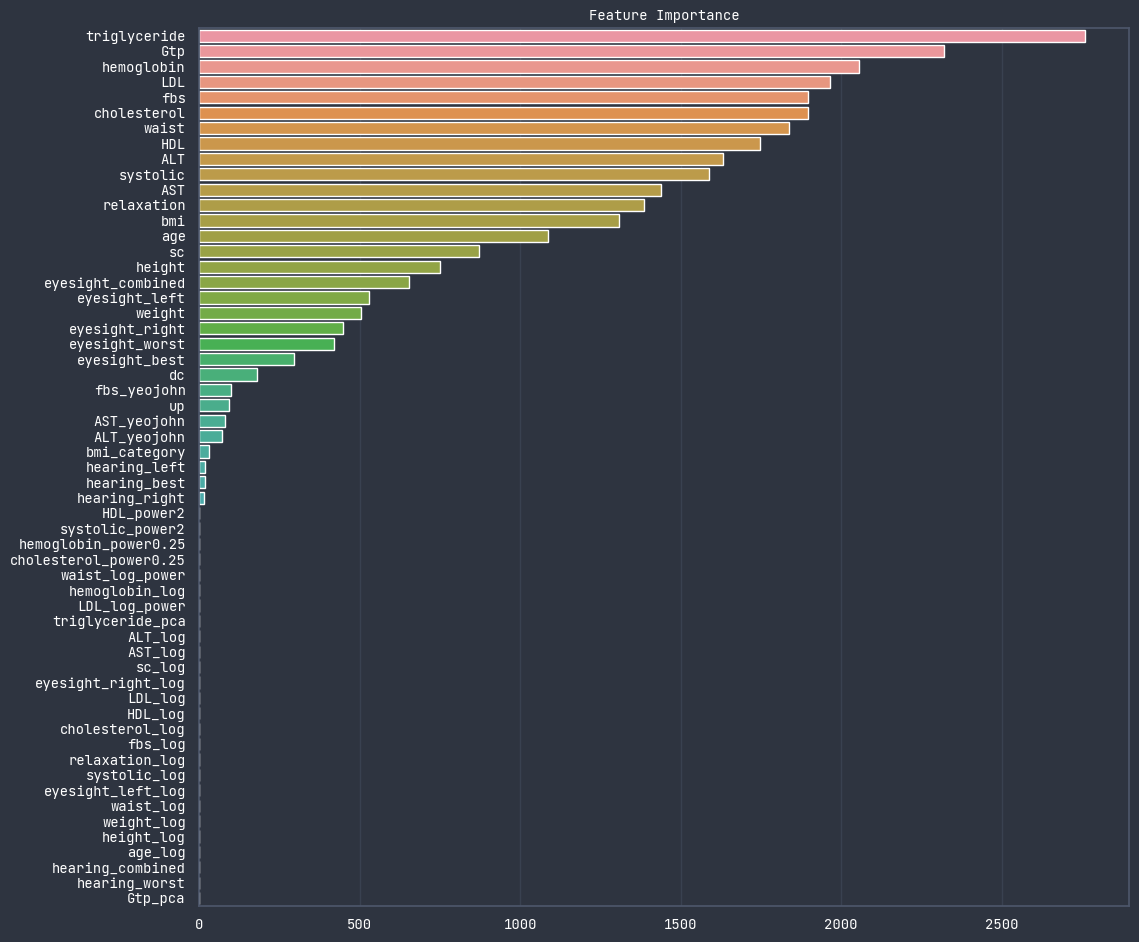

In [154]:
model = LGBMClassifier(
        n_estimators=1000,
        max_depth=10,
        random_state=2023,
        verbose=-1
    )
model.fit(cleaned_train_df.drop(target_var, axis=1), cleaned_train_df[target_var])

feat_imp = pd.DataFrame({
    'feat': cleaned_train_df.drop(target_var, axis=1).columns,
    'importance': model.feature_importances_
})
feat_imp.sort_values(by='importance', ascending=False, inplace=True)

fig = plt.figure(figsize=(12, 0.2*len(feat_imp)))
sns.barplot(data=feat_imp, x='importance', y='feat')
plt.title('Feature Importance')
plt.xlabel('')
plt.ylabel('')
plt.show()

## Ensemble

In [2]:
lgb_params = {
    "objective": 'binary',
    'metric': 'auc',
    'boosting_type': 'dart',
     "n_estimators": 1000,
     "max_depth": 7,
     "learning_rate":0.03,
     "num_leaves": 50,
     "reg_alpha":3,
     "reg_lambda": 3,
     "subsample": 0.7,
     "colsample_bytree": 0.7
}

xgb_params = {
    'n_estimators': 10000,
    'learning_rate': 0.01752354328845971,
    'booster': 'gbtree',
    'lambda': 0.08159630121074074,
    'alpha': 0.07564858712175693,
    'subsample': 0.5065979400270813,
    'colsample_bytree': 0.6187340851873067,
    'max_depth': 4,
    'min_child_weight': 5,
    'eta': 0.2603059902806757,
    'gamma': 0.6567360773618207,
    'tree_method': 'hist',
    'random_state': 2023
}

cat_params = {
    'iterations': 10000,
    'eval_metric': 'AUC',
    'loss_function': 'Logloss',
    'auto_class_weights': 'Balanced'
}

models = {
    'LGBM': LGBMClassifier(**lgb_params),
    'XGB': XGBClassifier(**xgb_params), 
    'Cat': CatBoostClassifier(**cat_params),
    'RF': RandomForestClassifier(),
    'Hist':HistGradientBoostingClassifier()
}

model_preds = {}

In [ ]:
n_folds = 3
k_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=1, random_state=2023)

final_train_df = cleaned_train_df.drop(target_var, axis=1)
target = cleaned_train_df[target_var]

for fold, (train_idx, test_idx) in enumerate(k_fold.split(final_train_df, target)):
    X_train, X_valid = final_train_df.iloc[train_idx], final_train_df.iloc[test_idx]
    y_train, y_valid = target.iloc[train_idx], target.iloc[test_idx]

# Submission

In [155]:
test_preds = model.predict_proba(cleaned_test_df)[:, 1]

submission = pd.read_csv('sample_submission.csv')
submission['smoking'] = test_preds
submission.to_csv('submission.csv', index=False)